In [1]:
from IPython.display import display
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import FormatStrFormatter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import spacy

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.max_colwidth', None)

%matplotlib inline


In [2]:
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec

wl = WordNetLemmatizer()
snow = SnowballStemmer('english')


[nltk_data] Downloading package punkt to /home/mikes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/mikes/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/mikes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mikes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
vd = pd.read_csv("/home/mikes/Windows/Documents/tmp/VAERS data deaths only Edited for NLP for HAD COVID.csv", 
                         delimiter = ",", 
                         encoding = "ISO-8859-1")

In [4]:
vd. columns

Index(['VAERS_ID', 'RECVDATE', 'STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX',
       'RPT_DATE', 'SYMPTOM_TEXT', 'SYMPTOM_TEXT_TARGET', 'DIED', 'DATEDIED',
       'L_THREAT', 'ER_VISIT', 'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE',
       'RECOVD', 'VAX_DATE', 'ONSET_DATE', 'NUMDAYS', 'LAB_DATA',
       'LAB_DATA_TARGET', 'V_ADMINBY', 'V_FUNDBY', 'OTHER_MEDS',
       'OTHER_MEDS_TARGET', 'CUR_ILL', 'CUR_ILL_TARGET', 'HISTORY',
       'PRIOR_VAX', 'SPLTTYPE', 'FORM_VERS', 'TODAYS_DATE', 'BIRTH_DEFECT',
       'OFC_VISIT', 'ER_ED_VISIT', 'ALLERGIES'],
      dtype='object')

In [5]:
df_train = vd.loc[vd['SYMPTOM_TEXT_TARGET'].notnull(), ['VAERS_ID','SYMPTOM_TEXT', 'SYMPTOM_TEXT_TARGET' ]]
df_train.shape

(202, 3)

In [6]:
df_test = vd.loc[vd['SYMPTOM_TEXT_TARGET'].isnull(), ['VAERS_ID','SYMPTOM_TEXT', 'SYMPTOM_TEXT_TARGET' ]]
df_test.shape

(4982, 3)

In [7]:
# No lost rows. All data accounted for
print(vd.shape)
print(df_train.shape[0] + df_test.shape[0])


(5184, 39)
5184


In [8]:
df_train.isna().sum()

VAERS_ID               0
SYMPTOM_TEXT           0
SYMPTOM_TEXT_TARGET    0
dtype: int64

In [9]:
df_test.isna().sum()

VAERS_ID                  0
SYMPTOM_TEXT              1
SYMPTOM_TEXT_TARGET    4982
dtype: int64

In [10]:
# WORD-COUNT (No apparent significance)
df_train['word_count'] = df_train['SYMPTOM_TEXT'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['SYMPTOM_TEXT_TARGET']==1]['word_count'].mean()) #Has covid
print(df_train[df_train['SYMPTOM_TEXT_TARGET']==0]['word_count'].mean()) #Does not have covid

100.20792079207921
104.03960396039604


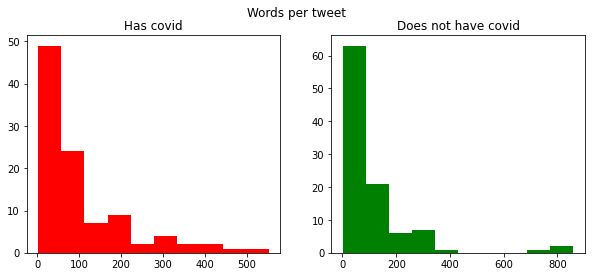

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['SYMPTOM_TEXT_TARGET']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Has covid')
train_words=df_train[df_train['SYMPTOM_TEXT_TARGET']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Does not have covid')
fig.suptitle('Words per tweet')
plt.show()

In [12]:
#convert to lowercase and remove punctuations and characters and then strip
def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text

 


In [13]:
#1. STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#2. STEMMING 
# Initialize the stemmer
snow = SnowballStemmer('english')
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)

#3. LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
# Full list is available here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

def finalpreprocess(string):
    string = str(string)
    return lemmatizer(stopword(preprocess(string)))
#    return lemmatizer(preprocess(string))

In [14]:
if "apple" in stopwords.words('english'): print(1)

In [15]:
df_train['clean_text'] = df_train['SYMPTOM_TEXT'].apply(lambda x: finalpreprocess(x))
#df_train=df_train.drop(columns=['word_count','char_count','unique_word_count'])
df_train.head()

,VAERS_ID,SYMPTOM_TEXT,SYMPTOM_TEXT_TARGET,word_count,clean_text
0,916803,respitory colase,0.0,2,respitory colase
1,917117,"After vaccination, patient tested positive for COVID-19. Patient was very ill and had numerous chronic health issues prior to vaccination. Facility had a number of patients who had already tested positive for COVID-19. Vaccination continued in an effort to prevent this patient from contracting the virus or to mitigate his risk. This was unsuccessful and patient died.",1.0,57,vaccination patient test positive covid patient ill numerous chronic health issue prior vaccination facility number patient already test positive covid vaccination continue effort prevent patient contract virus mitigate risk unsuccessful patient die
2,917790,"At the time of vaccination, there was an outbreak of residents who had already tested positive for COVID 19 at the nursing home where patient was a resident. About a week later, patient tested positive for COVID 19. She had a number of chronic, underlying health conditions. The vaccine did not have enough time to prevent COVID 19. There is no evidence that the vaccination caused patient's death. It simply didn't have time to save her life.",1.0,77,time vaccination outbreak resident already test positive covid nursing home patient resident week later patient test positive covid number chronic underlying health condition vaccine enough time prevent covid evidence vaccination cause patient death simply time save life
3,917793,"Prior to the administration of the COVID 19 vaccine, the nursing home had an outbreak of COVID-19. Patient was vaccinated and about a week later she tested positive for COVID-19. She had underlying thyroid and diabetes disease. She died as a result of COVID-19 and her underlying health conditions and not as a result of the vaccine.",1.0,57,prior administration covid vaccine nursing home outbreak covid patient vaccinate week later test positive covid underlie thyroid diabetes disease die result covid underlie health condition result vaccine
5,918388,"Resident found unresponsive without pulse, respirations at 04:30 CPR performed, expired at 04:52 by Rescue",0.0,15,resident find unresponsive without pulse respiration cpr perform expire rescue


In [16]:
# create Word2vec model
#  here words_f should be a list containing words from each document. say 1st row of the list is words from the 1st document/sentence
#  length of words_f is number of documents/sentences in your dataset
df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(df_train['clean_text_tok'],min_count=1)  #min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it

w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))  #combination of word and its vector
#w2v = dict(zip(model.wv.index_to_key, model.wv.syn0))  #combination of word and its vector
#w2v = dict(zip(model.wv.index2word, model.wv.syn0))  #combination of word and its vector

#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [17]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Input: "reviewText", "rating" and "time"
# Target: "log_votes"
X_train, X_val, y_train, y_val = train_test_split(df_train["clean_text"],
                                                  df_train["SYMPTOM_TEXT_TARGET"],
                                                  test_size=0.2,
                                                  shuffle=True)
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec

#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your test data: it will 
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible


#Word2vec
# Fit and transform
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

The support is the number of occurrences of each class in y_true.

If pos_label is None and in binary classification, this function returns the average precision, recall and F-measure if average is one of 'micro', 'macro', 'weighted' or 'samples'.

Read more in the [User Guide](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics).

In [18]:

# def logistic_regression_tfidf(df_train, df_test, ID, TEXT, TARGET, perc_cutoff = 80):
#     if perc_cutoff > 1: perc_cutoff = perc_cutoff/100
#     df_train = df_train.loc[df_train[TARGET].notnull(), [ID, TEXT, TARGET ]]
#     df_train['word_count'] = df_train[TEXT].apply(lambda x: len(str(x).split()))
#     #print(df_train[df_train[TARGET]==1]['word_count'].mean()) #Positive match
#     #print(df_train[df_train[TARGET]==0]['word_count'].mean()) #Not positive match 
#     df_train['clean_text'] = df_train[TEXT].apply(lambda x: finalpreprocess(x))
#     # create Word2vec model
#     #  here words_f should be a list containing words from each document. say 1st row of the list is words from the 1st document/sentence
#     #  length of words_f is number of documents/sentences in your dataset
#     df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']] #convert preprocessed sentence to tokenized sentence
#     model = Word2Vec(df_train['clean_text_tok'],min_count=1)  #min_count=1 means word should be present at least across all documents,
#     #if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it
#     w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))  #combination of word and its vector
#     #w2v = dict(zip(model.wv.index_to_key, model.wv.syn0))  #combination of word and its vector
#     #w2v = dict(zip(model.wv.index2word, model.wv.syn0))  #combination of word and its vector

#     ######################################################################
    
#     #FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
#     lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
#     lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#     #Predict y value for test dataset
#     y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
#     y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]


#     print(classification_report(y_val,y_predict))
#     print('Confusion Matrix:',confusion_matrix(y_val, y_predict))

#     fpr, tpr, thresholds = roc_curve(y_val, y_prob)
#     roc_auc = auc(fpr, tpr)
#     print('AUC:', roc_auc)

#     df_test['clean_text'] = df_test['SYMPTOM_TEXT'].apply(lambda x: finalpreprocess(x)) #preprocess the data
#     X_test=df_test['clean_text'] 
#     X_vector=tfidf_vectorizer.transform(X_test) #converting X_test to vector
#     y_predict = lr_tfidf.predict(X_vector)      #use the trained model on X_vector
#     y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
#     df_test['predict_prob']= y_prob
#     df_test['target']= y_predict
#     # display(df_test[['VAERS_ID','SYMPTOM_TEXT','predict_prob','target']].head())
#     # #final=df_test[['id','target']].reset_index(drop=True)
#     # #final.to_csv('submission.csv')
#     df_results = df_test[(
#                             (df_test["target"] == 1) & 
#                             (df_test["predict_prob"] >= perc_cutoff)
#     )]
#     print("{}/{}".format(df_results.shape[0], df_test.shape[0]))
#     display(df_had_covid_test)

# df_train = vd.loc[vd['SYMPTOM_TEXT_TARGET'].notnull(), ['VAERS_ID','SYMPTOM_TEXT', 'SYMPTOM_TEXT_TARGET' ]]
# logistic_regression_tfidf(df_train, vd, 'VAERS_ID', 'SYMPTOM_TEXT', 'SYMPTOM_TEXT_TARGET')


In [19]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]


print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))

fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90        27
         1.0       0.76      0.93      0.84        14

    accuracy                           0.88        41
   macro avg       0.86      0.89      0.87        41
weighted avg       0.89      0.88      0.88        41

Confusion Matrix: [[23  4]
 [ 1 13]]
AUC: 0.9682539682539684


In [20]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
#It's a probabilistic classifier that makes use of Bayes' Theorem, a rule that uses probability to make predictions based on prior knowledge of conditions that might be related. This algorithm is the most suitable for such large dataset as it considers each feature independently, calculates the probability of each category, and then predicts the category with the highest probability.

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_val_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)


              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50        27
         1.0       0.44      1.00      0.61        14

    accuracy                           0.56        41
   macro avg       0.72      0.67      0.55        41
weighted avg       0.81      0.56      0.54        41

Confusion Matrix: [[ 9 18]
 [ 0 14]]
AUC: 0.9497354497354497


In [21]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = lr_w2v.predict(X_val_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_val_vectors_w2v)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

         0.0       0.90      0.67      0.77        27
         1.0       0.57      0.86      0.69        14

    accuracy                           0.73        41
   macro avg       0.74      0.76      0.73        41
weighted avg       0.79      0.73      0.74        41

Confusion Matrix: [[18  9]
 [ 2 12]]
AUC: 0.8148148148148149


In [22]:

#Testing it on test dataset with the best model (Logistic Regression(tf-idf))
df_test['clean_text'] = df_test['SYMPTOM_TEXT'].apply(lambda x: finalpreprocess(x)) #preprocess the data
X_test=df_test['clean_text'] 
X_vector=tfidf_vectorizer.transform(X_test) #converting X_test to vector
y_predict = lr_tfidf.predict(X_vector)      #use the trained model on X_vector
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
df_test['predict_prob']= y_prob
df_test['target']= y_predict
display(df_test.head())
#final=df_test[['id','target']].reset_index(drop=True)
#final.to_csv('submission.csv')

,VAERS_ID,SYMPTOM_TEXT,SYMPTOM_TEXT_TARGET,clean_text,predict_prob,target
4,918065,1/1/2020: Residents was found unresponsive. Pronounced deceased at 6:02pm,NaN,resident find unresponsive pronounced decease pm,0.022736,0.0
10,919537,Resident exhibited no adverse events during 30 minute monitoring following vaccine administration. Resident found without pulse at 1900.,NaN,resident exhibit adverse event minute monitoring follow vaccine administration resident find without pulse,0.070013,0.0
19,921547,"DEATH ON 1/4/2021, RESIDENT RECIEVED VACCINE ON 1/2/20",NaN,death resident recieved vaccine,0.084419,0.0
75,934507,Resident died suddenly and expectantly on 01/05/2021,NaN,resident die suddenly expectantly,0.129098,0.0
76,934539,"Patient received COVID-19 (Moderna) vaccine from the Health Department on afternoon of January 8, 2021 and went to sleep approximately 2300 that night. Was found unresponsive in bed the following morning and pronounced dead at 1336 on January 9, 2021",NaN,patient receive covid moderna vaccine health department afternoon january go sleep approximately night find unresponsive bed follow morning pronounce dead january,0.391957,0.0


In [23]:
#Testing it on complete dataset with the best model (Logistic Regression(tf-idf)) to gather actual number 
# of patients who died after positive covid diagnosis
vd['clean_text'] = vd['SYMPTOM_TEXT'].apply(lambda x: finalpreprocess(x)) #preprocess the data
X_test=vd['clean_text'] 
X_vector=tfidf_vectorizer.transform(X_test) #converting X_test to vector
y_predict = lr_tfidf.predict(X_vector)      #use the trained model on X_vector
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
vd['predict_prob']= y_prob
vd['target']= y_predict
display(vd[['VAERS_ID','SYMPTOM_TEXT','predict_prob','target']].head())
#final=df_test[['id','target']].reset_index(drop=True)
#final.to_csv('submission.csv')

,VAERS_ID,SYMPTOM_TEXT,predict_prob,target
0,916803,respitory colase,0.111046,0.0
1,917117,"After vaccination, patient tested positive for COVID-19. Patient was very ill and had numerous chronic health issues prior to vaccination. Facility had a number of patients who had already tested positive for COVID-19. Vaccination continued in an effort to prevent this patient from contracting the virus or to mitigate his risk. This was unsuccessful and patient died.",0.919743,1.0
2,917790,"At the time of vaccination, there was an outbreak of residents who had already tested positive for COVID 19 at the nursing home where patient was a resident. About a week later, patient tested positive for COVID 19. She had a number of chronic, underlying health conditions. The vaccine did not have enough time to prevent COVID 19. There is no evidence that the vaccination caused patient's death. It simply didn't have time to save her life.",0.906094,1.0
3,917793,"Prior to the administration of the COVID 19 vaccine, the nursing home had an outbreak of COVID-19. Patient was vaccinated and about a week later she tested positive for COVID-19. She had underlying thyroid and diabetes disease. She died as a result of COVID-19 and her underlying health conditions and not as a result of the vaccine.",0.958349,1.0
4,918065,1/1/2020: Residents was found unresponsive. Pronounced deceased at 6:02pm,0.022736,0.0


# Conclusions
The best predictive results were from **Logistic Regression(tf-idf)**. Will be using this for the rest of the text analyses.